## Outliers
Sometimes our data is not nice enough to simply have a NaN or zero value to make it easy to tell what we should remove. Sometimes our data has outliers in it. So lets look at some strategies to identifying there points.

(1010,) (1010, 2)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


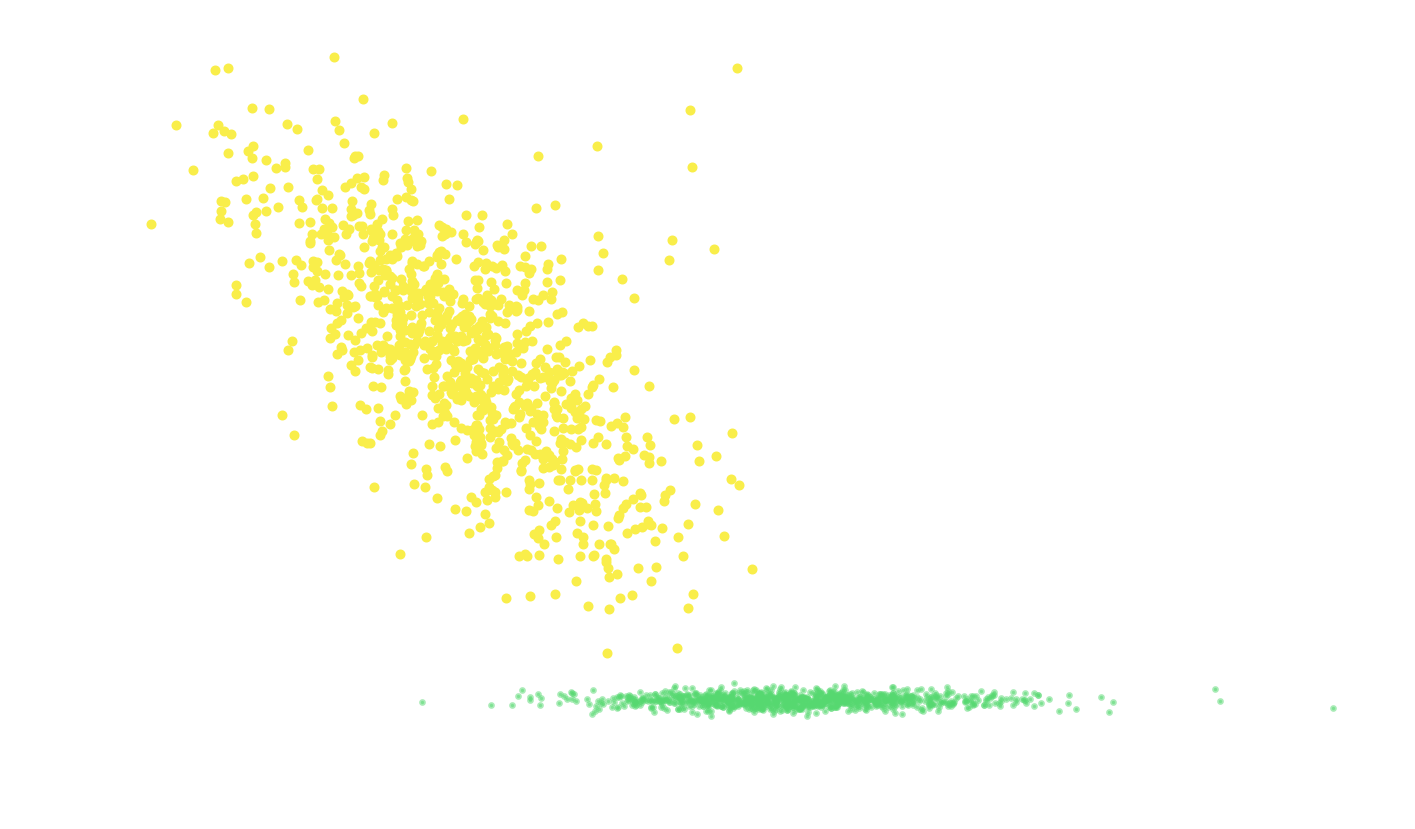

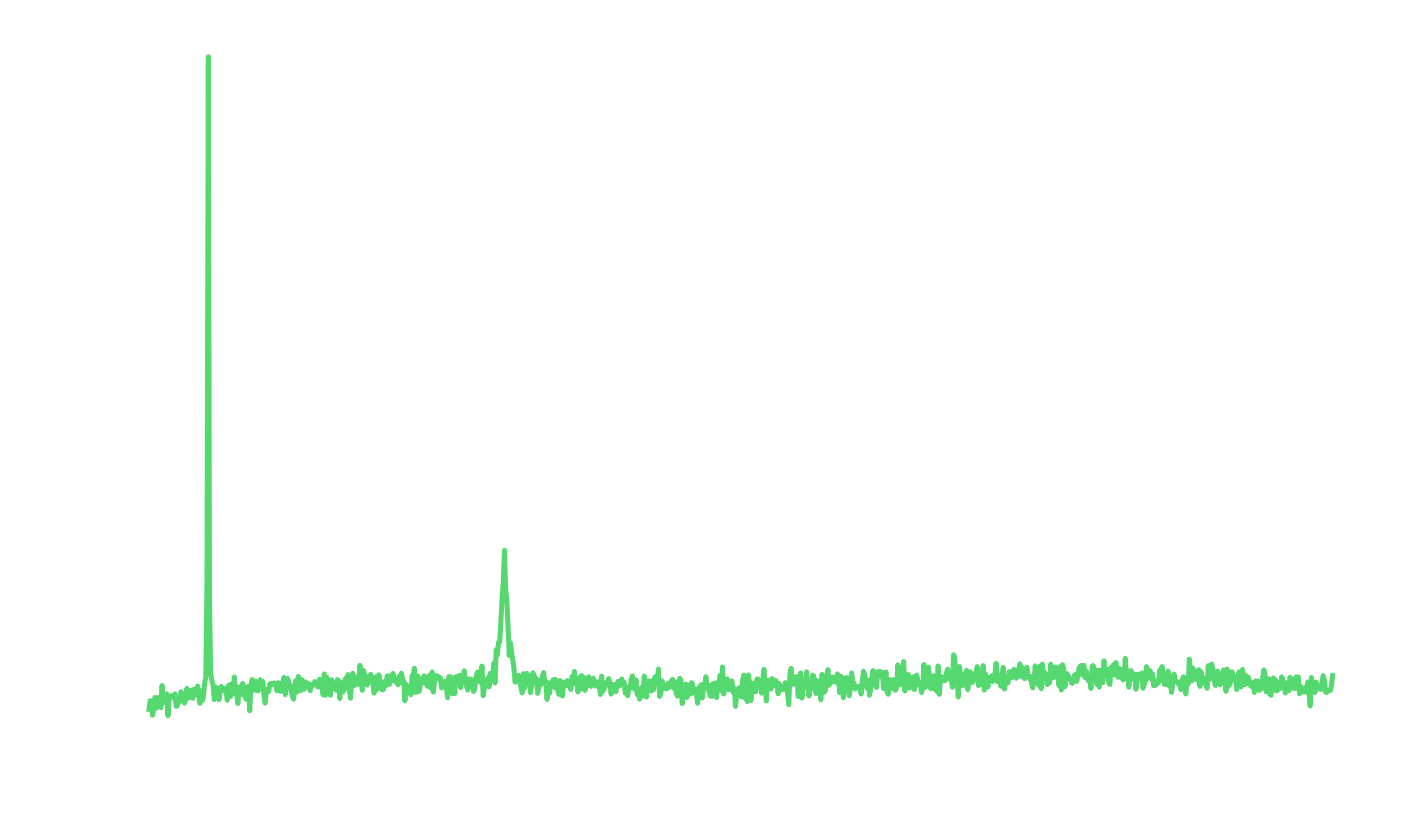

In [3]:
import numpy as np
import matplotlib.pyplot as plt

d1 = np.loadtxt('../data/outlier_1d.txt')
d2 = np.loadtxt('../data/outlier_2d.txt')
d3 = np.loadtxt('../data/outlier_curve.txt')
print(d1.shape, d2.shape)

plt.scatter(d1, np.random.normal(7, 0.2, size=d1.size), s=1, alpha=0.5)
plt.scatter(d2[:,0], d2[:,1])
plt.show();
plt.plot(d3[:,0], d3[:,1])

## Basics
The most basic and most-common way of manually doing outlier pruning on data distributions is to:
    1. Model your data as some analytic distribution
    2. Find all points below a certain probability
    3. Remove them
    4. Refit the distributions, and potentially run again from Step 1.

## Z-score
A Z-score is a numerical measurement used in statistics of a value's relationship to the mean (average) of a group of values, measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score

In [6]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} scipy

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\renat\Desktop\python-statistics\env

  added / updated specs:
    - scipy


The following NEW packages will be INSTALLED:

  scipy              pkgs/main/win-64::scipy-1.4.1-py38h9439919_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


Rejection 5 points
z-score of 3 corresponds to a prob of 0.27%


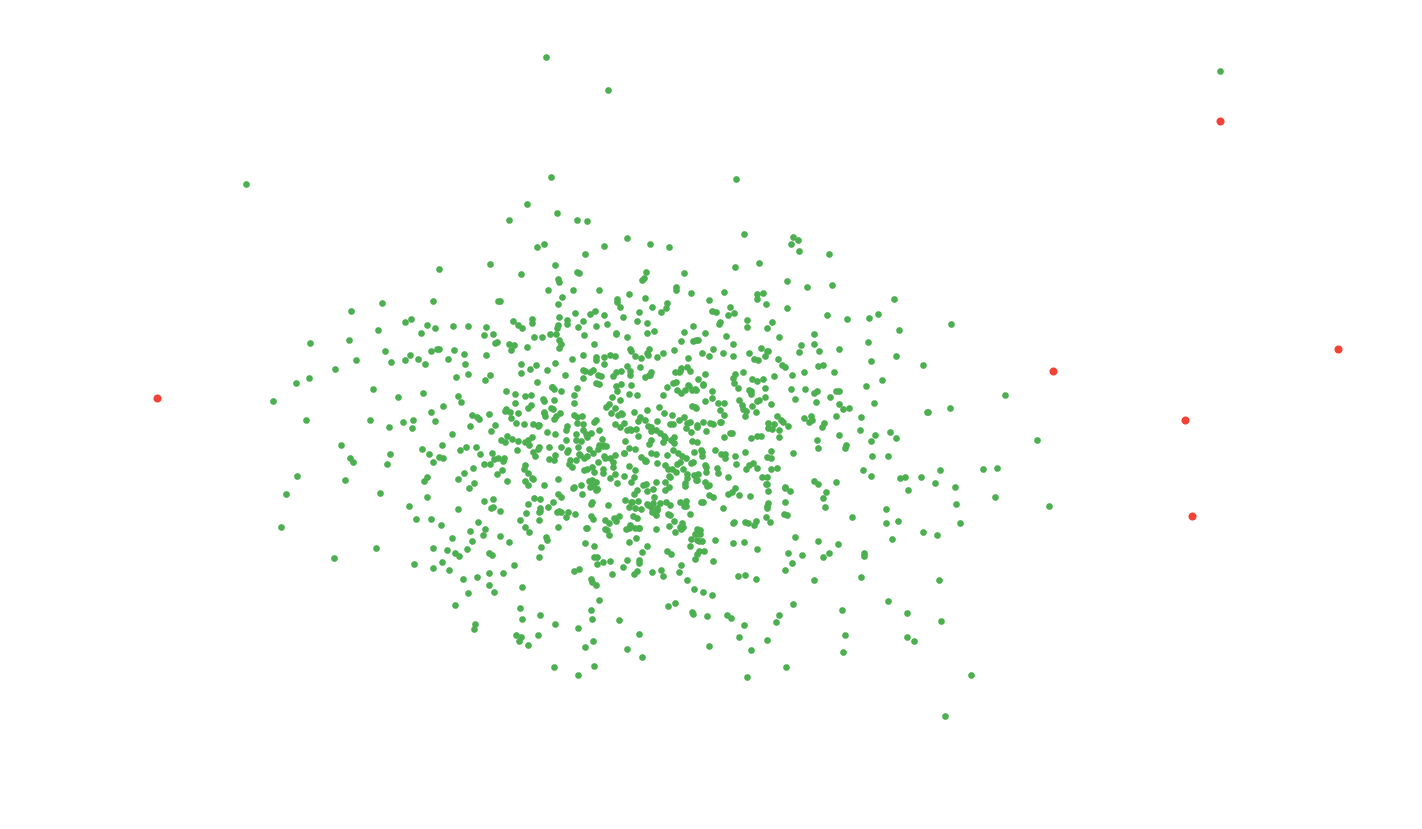

In [27]:
#1-dimensional array d1 -> z-score
mean, std = np.mean(d1), np.std(d1)
# how many standard deviation from the mean we are?
z_score = np.abs((d1 - mean) / std) 
threshold = 3
good = z_score < threshold

print(f'Rejection {(~good).sum()} points')
from scipy.stats import norm
print(f'z-score of 3 corresponds to a prob of {100 * 2 * norm.sf(threshold):0.2f}%')
visual_scatter = np.random.normal(size=d1.size)
plt.scatter(d1[good], visual_scatter[good], s=1, label='Good', color='#4CAF50')
plt.scatter(d1[~good], visual_scatter[~good], s=2, label='Bad', color='#F44336')
plt.legend();
                                

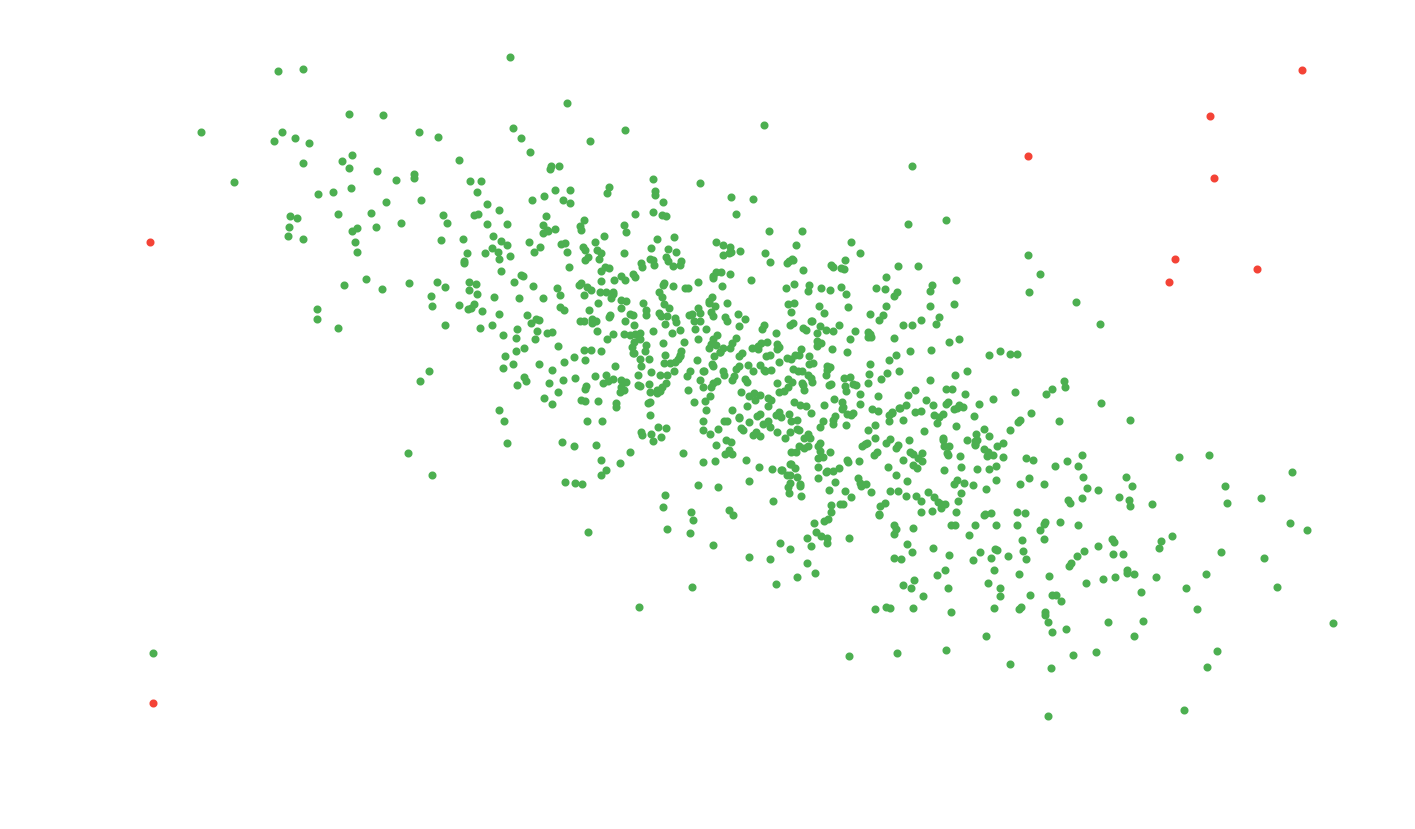

In [21]:
#2-dimensional array -> multivariate_normal
from scipy.stats import multivariate_normal as mn

mean, cov = np.mean(d2, axis=0), np.cov(d2.T)
good = mn(mean, cov).pdf(d2) > 0.01 / 100

plt.scatter(d2[good, 0], d2[good, 1], s=2, label="Good", color="#4CAF50")
plt.scatter(d2[~good, 0], d2[~good, 1], s=2, label="Bad", color="#F44336")
plt.legend();

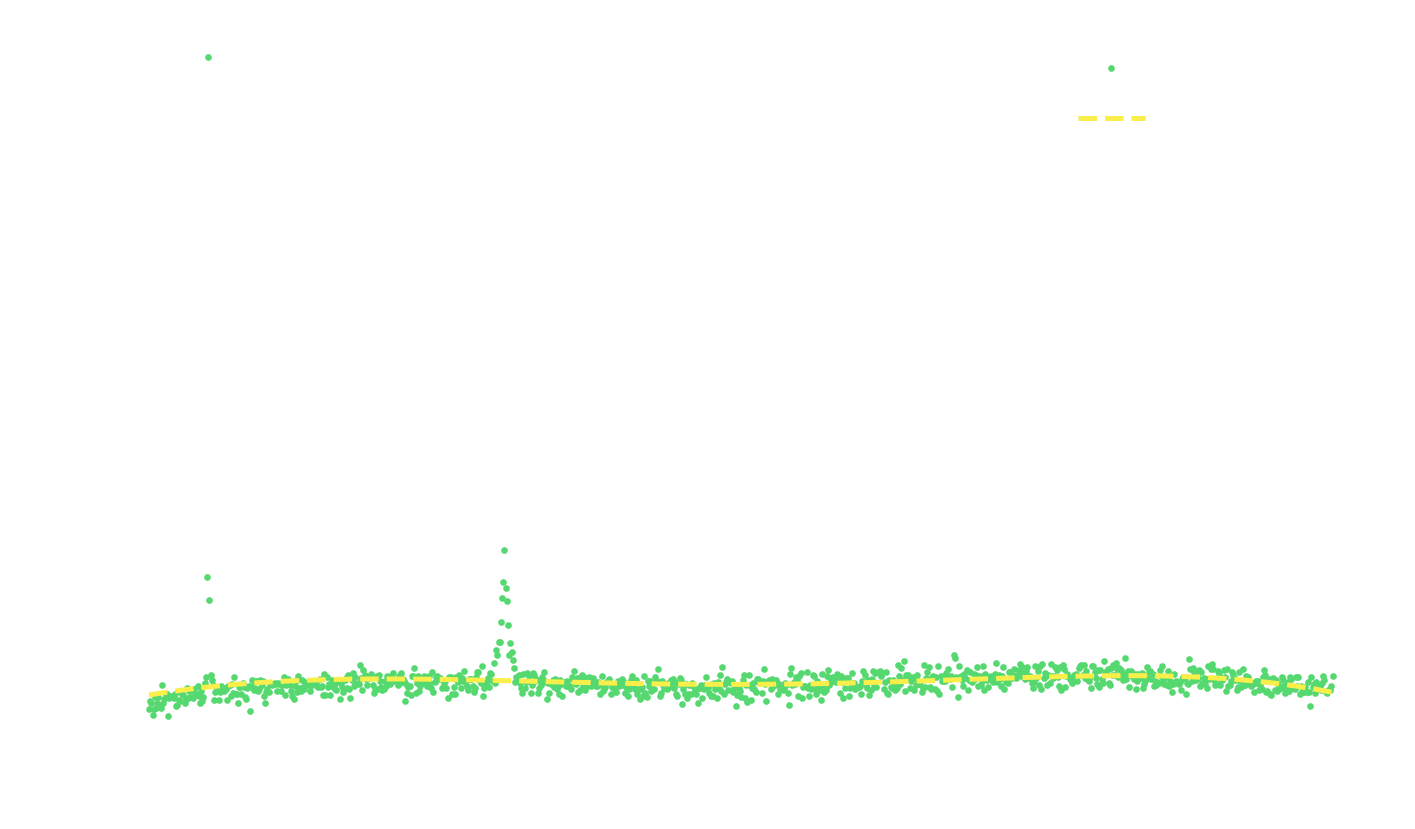

In [29]:
xs, ys = d3.T
p = np.polyfit(xs, ys, deg=5)
ps = np.polyval(p, xs)
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, ps, label="Bad poly fit")
plt.legend();


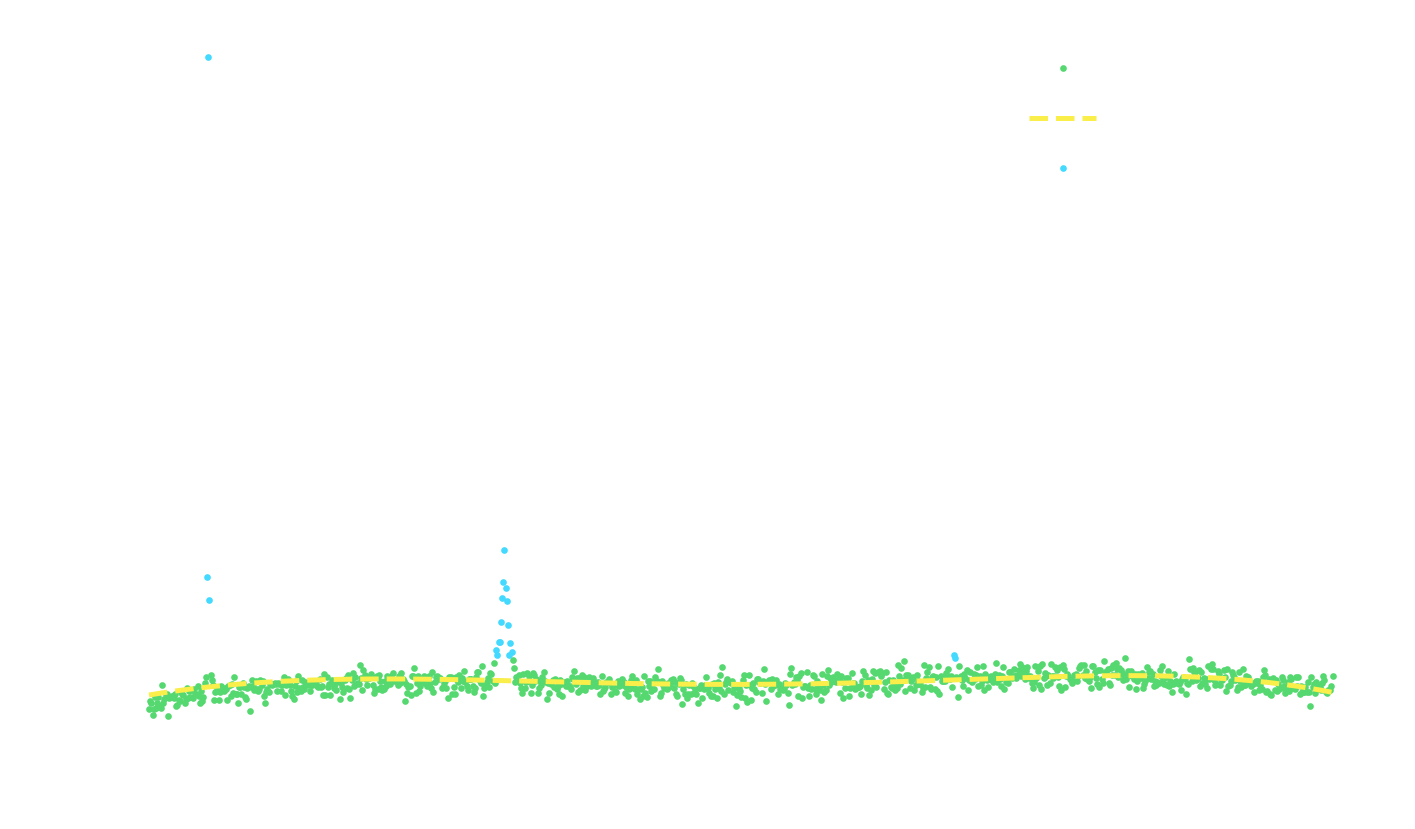

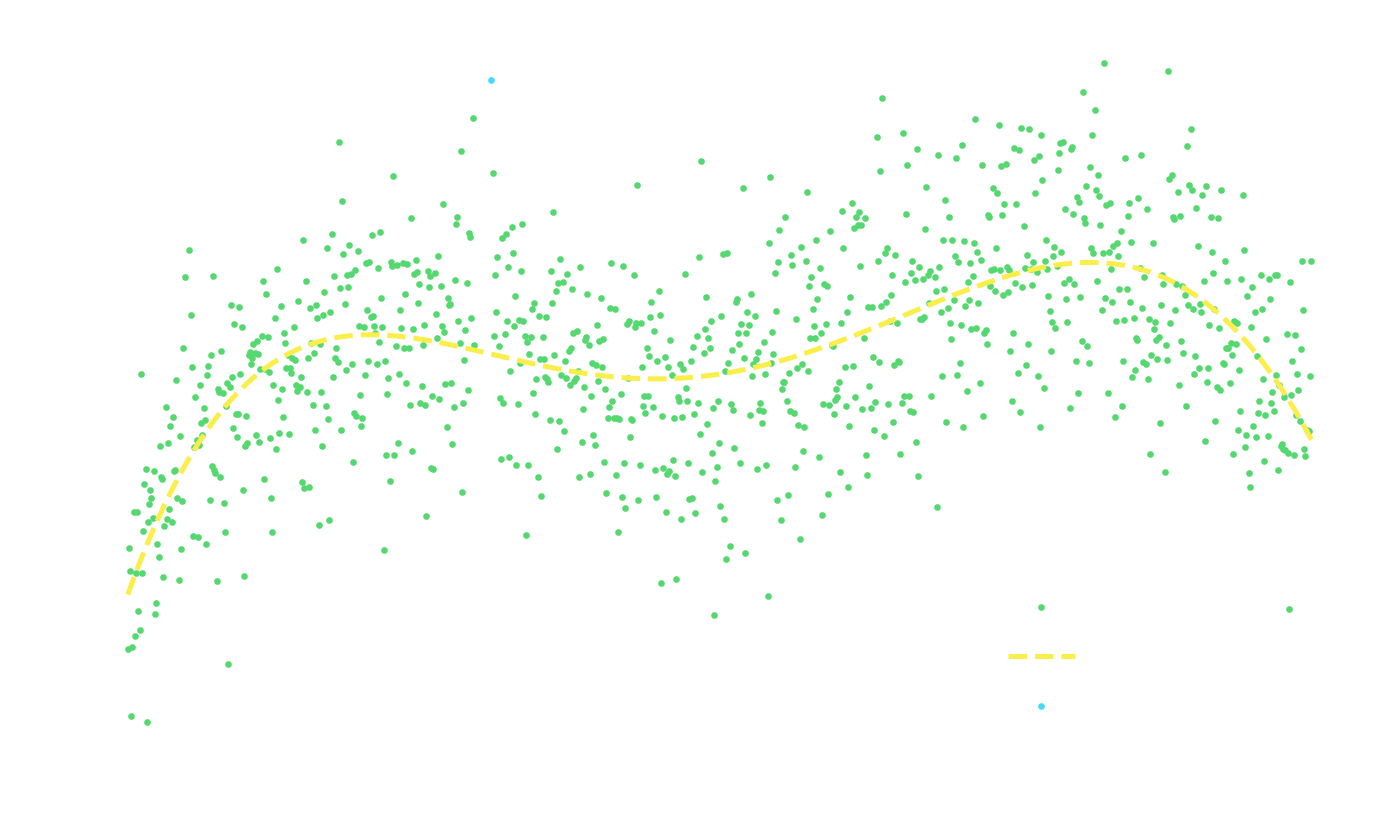

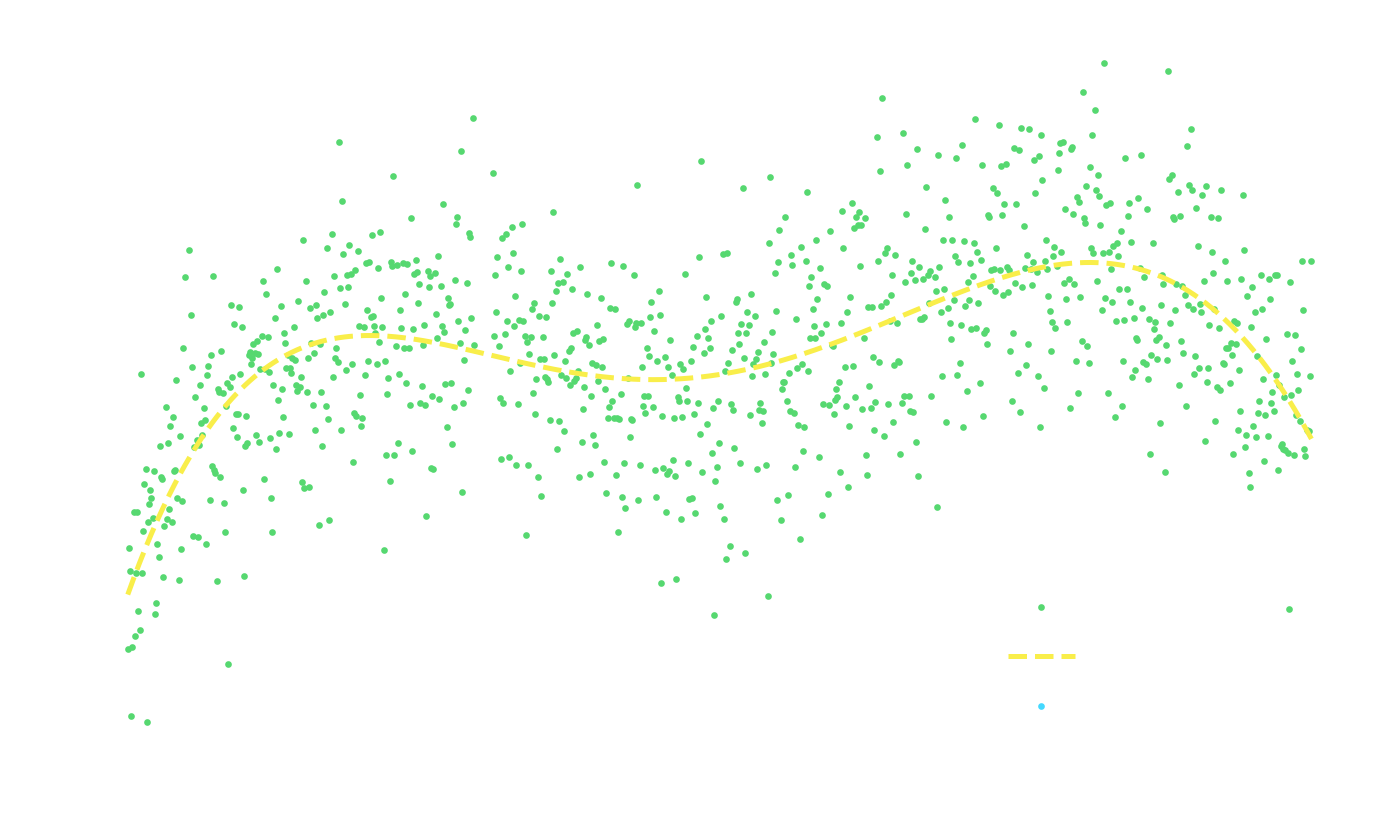

In [30]:
# The idea is to get rid of the outliers
x, y = xs.copy(), ys.copy()
# loop up to 5 times;
for i in range(5):
    p = np.polyfit(x, y, deg=5) # polyfit calculate the Least squares polynomial fit (indexes)
    ps = np.polyval(p, x)
    good = y - ps < 3 # only remove positive outliers
    
    x_bad, y_bad = x[~good], y[~good]
    x, y = x[good], y[good]
    
    plt.plot(x, y, '.', label='Used Data')
    plt.plot(x, np.polyval(p, x), label=f'Poly fit {i}')
    plt.plot(x_bad, y_bad, '.', label="Not used Data")
    plt.legend()
    plt.show()
    # if you don't have bad points stop iterating even though you haven't arrive at 5th;
    if(~good).sum() == 0:
        break
    

In [31]:
p

array([ 4.59221805e-04, -2.23483691e-02,  3.19234651e-01, -1.80903033e+00,
        4.11565871e+00,  2.08977136e+00])

In [32]:
ps 

array([2.08977136, 2.13074736, 2.17136347, 2.2116216 , 2.25152363,
       2.29107149, 2.33026704, 2.36911218, 2.4076088 , 2.44575876,
       2.48356393, 2.52102619, 2.55814738, 2.59492937, 2.631374  ,
       2.66748312, 2.70325856, 2.73870216, 2.77381575, 2.80860114,
       2.84306016, 2.87719461, 2.9110063 , 2.94449704, 2.97766862,
       3.01052283, 3.04306146, 3.07528629, 3.10719909, 3.13880163,
       3.17009567, 3.20108299, 3.23176532, 3.26214443, 3.29222205,
       3.32199993, 3.35147979, 3.38066336, 3.40955238, 3.43814855,
       3.46645359, 3.49446921, 3.52219711, 3.54963899, 3.57679654,
       3.60367145, 3.63026539, 3.65658006, 3.68261711, 3.78650195,
       3.811149  , 3.83552854, 3.85964218, 3.88349157, 3.90707833,
       3.93040408, 3.95347044, 3.97627902, 3.99883141, 4.02112923,
       4.04317407, 4.06496751, 4.08651115, 4.10780656, 4.12885533,
       4.14965901, 4.17021918, 4.1905374 , 4.21061521, 4.23045418,
       4.25005585, 4.26942175, 4.28855343, 4.30745242, 4.32612

## Automating it
Blessed sklearn to the rescue. Check out the main page which lists a ton of ways you can do outlier detection. I think LOF (Local Outlier Finder) is great - it uses the distance from one point to its closest twenty neighbours to figure out point density and removes those in low density regions.

In [33]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} scikit-learn

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\renat\Desktop\python-statistics\env

  added / updated specs:
    - scikit-learn


The following NEW packages will be INSTALLED:

  joblib             pkgs/main/noarch::joblib-0.14.1-py_0
  scikit-learn       pkgs/main/win-64::scikit-learn-0.22.1-py38h6288b17_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


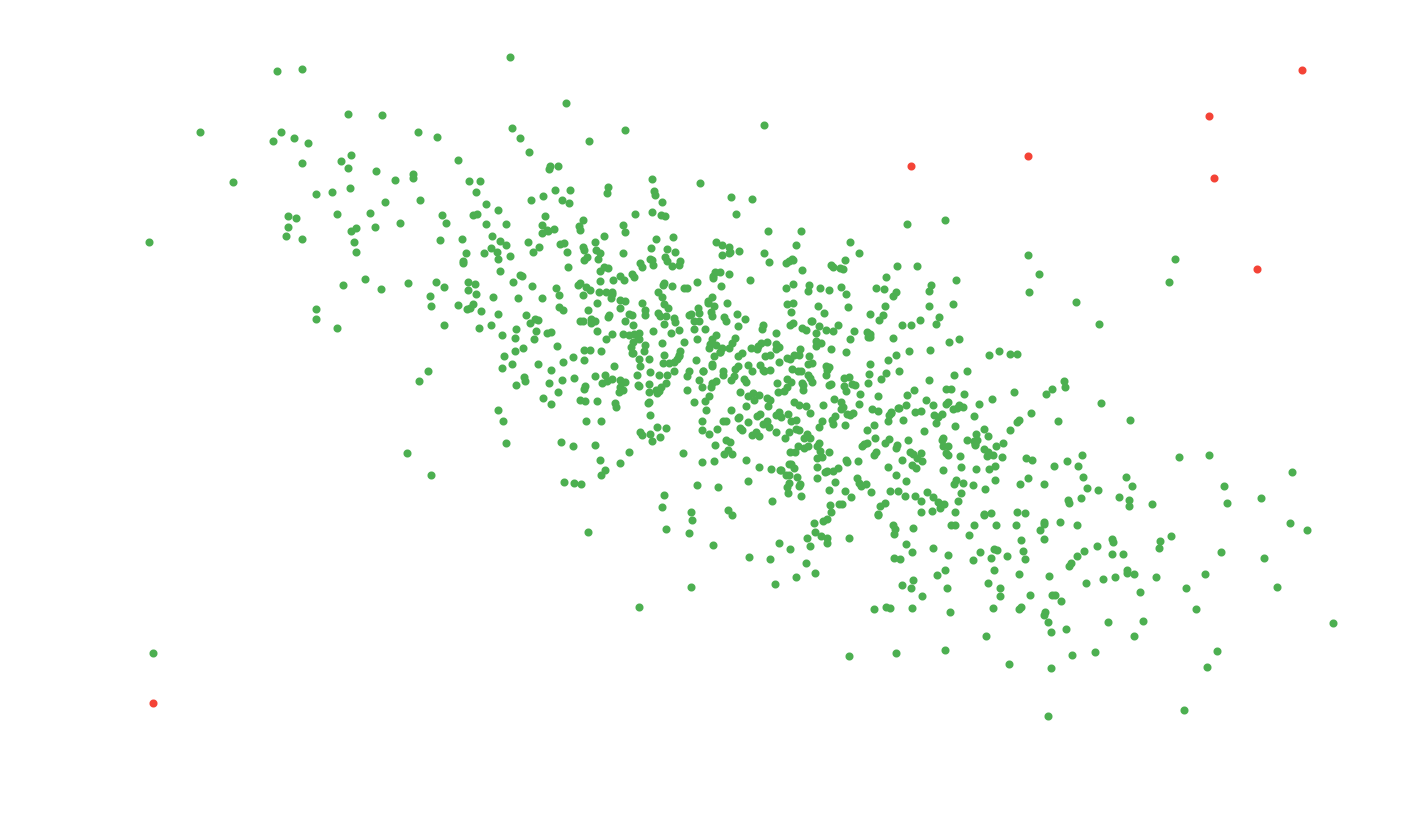

In [38]:
## Finding outliers using sklearn -> Automating which points are outliers
from sklearn.neighbors import LocalOutlierFactor

#10 outliers in 1000 elements 0.01 contaminarion
#Use the 20 k-neighrest neighbors
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.005) 
# lof return == 1 it is a data point, or lof == -1 it is an outlier
good = lof.fit_predict(d2) == 1
plt.scatter(d2[good, 0], d2[good, 1], s=2, label="Good", color="#4CAF50")
plt.scatter(d2[~good, 0], d2[~good, 1], s=2, label="Bad", color="#F44336")
plt.legend();
